In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.basics import *
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# Rossmann

## Data preparation / Feature engineering

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz). Then you shold untar them in the dirctory to which `PATH` is pointing below.

For completeness, the implementation used to put them together is included below.

In [4]:
untar_data('http://files.fast.ai/part2/lesson14/rossmann',dest='/content/data/rossmann')

PosixPath('/content/data/rossmann/rossmann')

In [5]:
(Config().data_path()/'rossmann').ls()

[PosixPath('/root/.fastai/data/rossmann/googletrend.csv'),
 PosixPath('/root/.fastai/data/rossmann/weather.csv'),
 PosixPath('/root/.fastai/data/rossmann/store_states.csv'),
 PosixPath('/root/.fastai/data/rossmann/state_names.csv'),
 PosixPath('/root/.fastai/data/rossmann/sample_submission.csv'),
 PosixPath('/root/.fastai/data/rossmann/train.csv'),
 PosixPath('/root/.fastai/data/rossmann/store.csv'),
 PosixPath('/root/.fastai/data/rossmann/test.csv')]

In [6]:
(Config().data_path()/'rossmann')

PosixPath('/root/.fastai/data/rossmann')

In [0]:
PATH=(Config().data_path()/'rossmann')

In [8]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
type(table_names)


list

In [0]:
??pd.read_csv

In [10]:
#PATH=Config().data_path()/Path('rossmann/')

tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

In [0]:
??train.isnull()

**Define functions for Data Exploration**

In [0]:
def data_shape_and_head(df):
    pd.set_option('float_format', '{:f}'.format)
    print(f"Data Frame Shape: {df.shape}")
    return df.head()

In [0]:
def percentage_of_null_data(df):
    pd.options.mode.use_inf_as_na=True
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [0]:
def unique_values_eachcolumn(df):
  for column in df.columns.values:
    print(f"[df] Unique values of '{column}' : {df[column].nunique()}")

In [0]:
def plot_col_count_4_top20(column_name, title, df, size=6):
  # Displays the count of records for each value of the column. 
  # Displays data for first 20 most frequent values
    import seaborn as sns
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[column_name], order = df[column_name].value_counts().index[:30], palette='Dark2')
    g.set_title("Number and Percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

In [0]:
def plot_most_or_least_populated_data(df,most=True):
  import seaborn as sns
  total = df.isnull().count() - df.isnull().sum()
  percent = 100 - (df.isnull().sum()/df.isnull().count()*100)
  tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  tt = pd.DataFrame(tt.reset_index())
  tt= (tt.sort_values(['Total'], ascending=most))
  plt.figure(figsize=(10, 8))
  sns.set(style='darkgrid')
  ax = sns.barplot(x='Percent', y='index', data=tt.head(30), color='DarkOrange')
  plt.title(('Most' if most else 'Least' ) + ' frequent columns/features in the dataframe')
  plt.ylabel('Features/Columns')
  plt.show()

**Do the data exploration for train Dataframe**

In [17]:
data_shape_and_head(train)


Data Frame Shape: (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [18]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000


In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.000000,558.429727,321.908651,1.000000,280.000000,558.000000,838.000000,1115.000000
DayOfWeek,1017209.000000,3.998341,1.997391,1.000000,2.000000,4.000000,6.000000,7.000000
Sales,1017209.000000,5773.818972,3849.926175,0.000000,3727.000000,5744.000000,7856.000000,41551.000000
Customers,1017209.000000,633.145946,464.411734,0.000000,405.000000,609.000000,837.000000,7388.000000
Open,1017209.000000,0.830107,0.375539,0.000000,1.000000,1.000000,1.000000,1.000000
Promo,1017209.000000,0.381515,0.485759,0.000000,0.000000,0.000000,1.000000,1.000000
SchoolHoliday,1017209.000000,0.178647,0.383056,0.000000,0.000000,0.000000,0.000000,1.000000


In [20]:
train.count()

Store            1017209
DayOfWeek        1017209
Date             1017209
Sales            1017209
Customers        1017209
Open             1017209
Promo            1017209
StateHoliday     1017209
SchoolHoliday    1017209
dtype: int64

In [21]:
train['DayOfWeek'].count()

1017209

In [22]:
unique_values_eachcolumn(train)

[df] Unique values of 'Store' : 1115
[df] Unique values of 'DayOfWeek' : 7
[df] Unique values of 'Date' : 942
[df] Unique values of 'Sales' : 21734
[df] Unique values of 'Customers' : 4086
[df] Unique values of 'Open' : 2
[df] Unique values of 'Promo' : 2
[df] Unique values of 'StateHoliday' : 4
[df] Unique values of 'SchoolHoliday' : 2


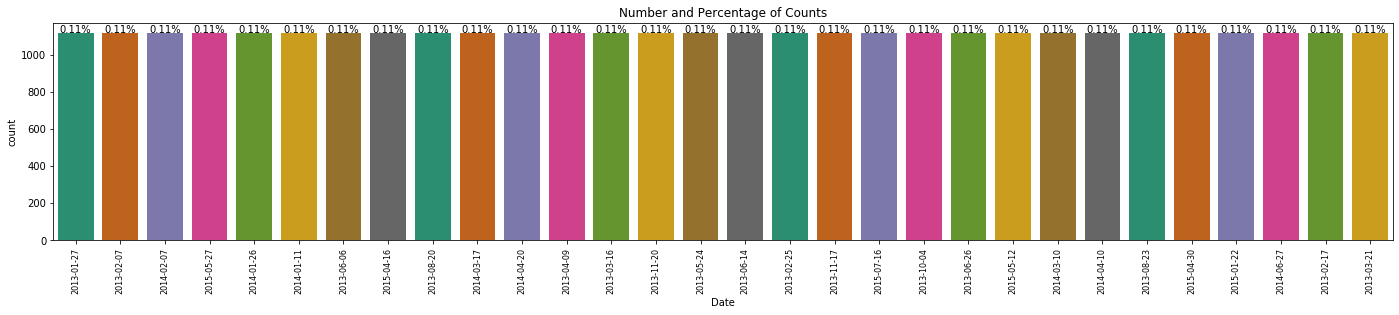

In [23]:
plot_col_count_4_top20('Date', 'Counts', train,size=6)

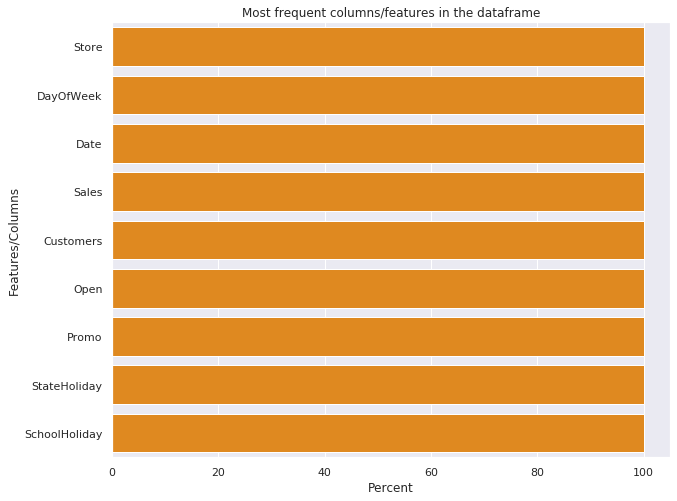

In [24]:
plot_most_or_least_populated_data(train)

In [25]:
train.DayOfWeek.nunique()

7

In [26]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [27]:
percentage_of_null_data(train)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Total,0,0,0,0,0,0,0,0,0
Percent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Types,int64,int64,object,int64,int64,int64,int64,object,int64


In [28]:
train.Date

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, Length: 1017209, dtype: object

In [29]:
train.groupby('Date').max().Sales

Date
2013-01-01    17267
2013-01-02    25357
2013-01-03    23303
2013-01-04    21996
2013-01-05    22521
              ...  
2015-07-27    27881
2015-07-28    25518
2015-07-29    25840
2015-07-30    24395
2015-07-31    27508
Name: Sales, Length: 942, dtype: int64

In [30]:
train.sample(5, random_state=300).groupby('Date').max().Customers

Date
2013-07-10    440
2014-05-09    540
2014-11-02      0
2015-04-06      0
2015-04-20    482
Name: Customers, dtype: int64

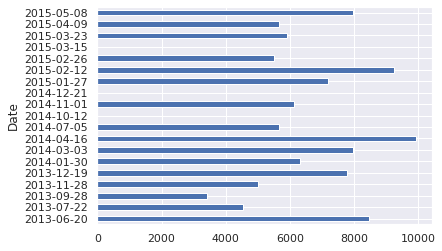

In [31]:
#train['Date', 'Sales']
train.sample(20, random_state=5).groupby('Date').max().Sales.plot(kind='barh')

In [32]:
train.groupby('DayOfWeek').DayOfWeek

In [33]:
(train.groupby('DayOfWeek').sum())

,Store,Sales,Customers,Open,Promo,SchoolHoliday
DayOfWeek,,,,,,
1,80821168,1130203012,117675012,137560,77760,34060
2,81344288,1020411930,110848063,143961,77580,36595
3,81345276,954962863,105117642,141936,77580,34636
4,81443338,911177709,101732938,134644,77580,34747
5,81443338,980555941,108384820,138640,77580,36235
6,80821168,846317735,95103854,144058,0,2724
7,80821168,29551433,5179426,3593,0,2724


In [35]:
train[0:10]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


**`We looked at the train data. Similarly we can look at other tabular data as well and figure out the features that we can use.`**

---



We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [0]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [0]:
??pd.merge()

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [0]:
weather = join_df(weather, state_names, "file", "StateName")

In [41]:
weather

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.000000,12.000000,4.000000,39,26,58.000000,5.080000,6.000000,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.000000,14.000000,10.000000,24,16,nan,0.000000,6.000000,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.000000,8.000000,2.000000,26,21,nan,1.020000,7.000000,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.000000,5.000000,2.000000,23,14,nan,0.250000,7.000000,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.000000,6.000000,3.000000,16,10,nan,0.000000,7.000000,Rain,268,NordrheinWestfalen,NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,Saarland,2015-09-13,21,17,12,16,14,12,100,88,68,1015,1010,1005,31.000000,15.000000,10.000000,27,10,50.000000,1.020000,7.000000,Rain,113,Saarland,SL
15836,Saarland,2015-09-14,18,14,11,15,12,7,99,85,61,1009,1005,1004,31.000000,13.000000,4.000000,32,16,53.000000,9.910000,5.000000,Rain-Thunderstorm,213,Saarland,SL
15837,Saarland,2015-09-15,16,12,9,11,8,7,93,77,62,1010,1008,1004,31.000000,12.000000,10.000000,34,14,nan,0.000000,5.000000,Rain,193,Saarland,SL
15838,Saarland,2015-09-16,19,15,11,16,13,10,97,90,75,1004,999,995,31.000000,10.000000,4.000000,32,14,45.000000,20.070000,7.000000,Rain-Thunderstorm,147,Saarland,SL


In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [60]:
googletrend.index[5]

5

In [61]:
googletrend.week.str.split(' - ', expand=True)[1]

0       2012-12-08
1       2012-12-15
2       2012-12-22
3       2012-12-29
4       2013-01-05
           ...    
2067    2015-09-05
2068    2015-09-12
2069    2015-09-19
2070    2015-09-26
2071    2015-10-03
Name: 1, Length: 2072, dtype: object

In [68]:
googletrend

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN
...,...,...,...,...,...
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95,2015-08-30,SL
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47,2015-09-06,SL
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80,2015-09-13,SL
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57,2015-09-20,SL


In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]


In [66]:
googletrend.loc[googletrend.State=='NI', "State"]

Series([], Name: State, dtype: object)

In [0]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [167]:
googletrend

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN
...,...,...,...,...,...
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95,2015-08-30,SL
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47,2015-09-06,SL
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80,2015-09-13,SL
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57,2015-09-20,SL


The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why not just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [81]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [0]:
??join_df

In [82]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [83]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [87]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [88]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [89]:
joined.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,trend,Month_y,Day_y,Dayofweek_y,Dayofyear_y,Elapsed_y,trend_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,WindDirDegrees,Year_y,Month_y,Week_y,Day_y,Dayofweek_y,Dayofyear_y,Elapsed_y
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1014567.000000,693861.000000,693861.000000,1017209.000000,509178.000000,509178.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,992564.000000,992564.000000,992564.000000,1017209.000000,1017209.000000,236167.000000,1017209.000000,936890.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,2013.832292,5.846762,23.615515,15.702790,2.998341,162.276385,1397179842.846062,5430.085652,7.222866,2008.690228,0.500564,23.269093,2011.752774,65.219190,5.891212,15.562106,6.000000,163.476310,1397283516.407739,66.234798,5.891212,15.562106,6.000000,163.476310,1397283516.407739,14.328300,10.073856,5.900282,8.216752,5.835002,3.263247,93.283786,73.952151,49.923426,1018.644120,1015.429182,1012.428608,23.542818,12.127392,7.284987,22.672915,11.870788,48.459272,0.790271,5.521105,177.063058,2013.832292,5.846762,23.615515,15.702790,2.998341,162.276385,1397179842.846062
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056,0.777396,3.326097,14.433381,8.787638,1.997391,101.616189,23712834.841055,7715.323700,3.211832,5.992644,0.500000,14.095973,1.662870,11.339865,3.308500,8.802947,0.000000,101.235953,23757279.032632,9.618326,3.308500,8.802947,0.000000,101.235953,23757279.032632,8.464778,7.239083,6.459730,6.140112,5.993374,6.033076,7.717332,13.206449,19.626353,7.915110,8.248712,8.748368,9.222368,4.871022,4.771402,8.940418,5.897191,13.142078,2.502615,1.683795,101.748176,0.777396,3.326097,14.433381,8.787638,1.997391,101.616189,23712834.841055
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1356998400.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,28.000000,1.000000,1.000000,6.000000,4.000000,1357430400.000000,50.000000,1.000000,1.000000,6.000000,4.000000,1357430400.000000,-11.000000,-13.000000,-15.000000,-14.000000,-15.000000,-73.000000,44.000000,30.000000,4.000000,976.000000,974.000000,970.000000,0.000000,0.000000,0.000000,3.000000,2.000000,21.000000,0.000000,0.000000,-1.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1356998400.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000,2013.000000,3.000000,11.000000,8.000000,1.000000,77.000000,1376697600.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000,57.000000,3.000000,8.000000,6.000000,76.000000,1376784000.000000,58.000000,3.000000,8.000000,6.000000,76.000000,1376784000.000000,8.000000,4.000000,1.000000,3.000000,1.000000,-1.000000,88.000000,64.000000,34.000000,1014.000000,1011.000000,1007.000000,11.000000,10.000000,3.00

In [91]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
          if c in df.columns:
            print(c)

Date_y
Month_y
Day_y
Dayofweek_y
Dayofyear_y
Is_month_end_y
Is_month_start_y
Is_quarter_end_y
Is_quarter_start_y
Is_year_end_y
Is_year_start_y
Elapsed_y
file_y
Year_y
Month_y
Week_y
Day_y
Dayofweek_y
Dayofyear_y
Is_month_end_y
Is_month_start_y
Is_quarter_end_y
Is_quarter_start_y
Is_year_end_y
Is_year_start_y
Elapsed_y
Date_y
Month_y
Day_y
Dayofweek_y
Dayofyear_y
Is_month_end_y
Is_month_start_y
Is_quarter_end_y
Is_quarter_start_y
Is_year_end_y
Is_year_start_y
Elapsed_y
file_y
Year_y
Month_y
Week_y
Day_y
Dayofweek_y
Dayofyear_y
Is_month_end_y
Is_month_start_y
Is_quarter_end_y
Is_quarter_start_y
Is_year_end_y
Is_year_start_y
Elapsed_y


In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [104]:
joined.shape

(1017209, 74)

In [124]:
for column in joined.columns:
  print(column)

Store
DayOfWeek
Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday
Year
Month
Week
Day
Dayofweek
Dayofyear
Is_month_end
Is_month_start
Is_quarter_end
Is_quarter_start
Is_year_end
Is_year_start
Elapsed
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval
State
file
week
trend
file_DE
week_DE
trend_DE
Date_DE
State_DE
Month_DE
Day_DE
Dayofweek_DE
Dayofyear_DE
Is_month_end_DE
Is_month_start_DE
Is_quarter_end_DE
Is_quarter_start_DE
Is_year_end_DE
Is_year_start_DE
Elapsed_DE
Max_TemperatureC
Mean_TemperatureC
Min_TemperatureC
Dew_PointC
MeanDew_PointC
Min_DewpointC
Max_Humidity
Mean_Humidity
Min_Humidity
Max_Sea_Level_PressurehPa
Mean_Sea_Level_PressurehPa
Min_Sea_Level_PressurehPa
Max_VisibilityKm
Mean_VisibilityKm
Min_VisibilitykM
Max_Wind_SpeedKm_h
Mean_Wind_SpeedKm_h
Max_Gust_SpeedKm_h
Precipitationmm
CloudCover
Events
WindDirDegrees
StateName


In [127]:
len(joined.loc[joined.StateName.isna() , "StateName"])

0

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [132]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates. You may need to install the `isoweek` package first.

In [133]:
# If needed, uncomment:
 ! pip install isoweek

In [0]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [139]:
joined

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.000000,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.000000,15.000000,10.000000,24,11,nan,0.000000,1.000000,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,42214
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.000000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.000000,10.000000,10.000000,14,11,nan,0.000000,4.000000,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.000000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,21,13,6,10,7,4,100,61,24,1022,1019,1017,31.000000,14.000000,10.000000,14,5,nan,0.000000,2.000000,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.000000,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,14,9,9,7,4,94,61,30,1019,1017,1014,10.000000,10.000000,10.000000,23,16,nan,0.000000,6.000000,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,42214
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.000000,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.000000,10.000000,10.000000,14,11,nan,0.000000,4.000000,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,42214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,True,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,a,a,1900.000000,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,6,6,False,False,False,False,False,False,1357430400,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.000000,12.000000,4.000000,39,

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [141]:
  df.Promo2Weeks.unique()

array([ 0, 25, 24, 15, 20, 23, 14, 19, 22, 13, 18, 21, 12, 17, 11, 16, 10,  9,  8])

In [0]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [0]:
??df.sort_values()

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [150]:
df

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13.000000,nan
856,2015-09-16,1,1,False,0,12.000000,nan
1712,2015-09-15,1,1,False,0,11.000000,nan
2568,2015-09-14,1,1,False,0,10.000000,nan
3424,2015-09-13,1,0,False,0,9.000000,nan
...,...,...,...,...,...,...,...
1012749,2013-01-05,1115,0,False,1,0.000000,0.000000
1013864,2013-01-04,1115,0,False,1,0.000000,0.000000
1014979,2013-01-03,1115,0,False,1,0.000000,0.000000
1016094,2013-01-02,1115,0,False,1,0.000000,0.000000


We'll do this for two more fields.

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [0]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [158]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

AttributeError: ignored

In [159]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

AttributeError: ignored

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [160]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

NameError: ignored

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [0]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [0]:
df.to_pickle(PATH/'df')

In [155]:
df["Date"] = pd.to_datetime(df.Date)

AttributeError: ignored

In [0]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [0]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')